# Import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import pickle
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid


# Global params

In [2]:
DEVICE = "cpu"
ROOT = os.getcwd()
ENV_ARGS = {
    'id': 'BipedalWalker-v3'
    # 'continuous': True
}
EXP_NAME = f'bipedal'
OUTPUT = os.path.join(ROOT, 'output', EXP_NAME)

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

GAMMA = 0.99


In [3]:
def make_env(gamma, **env_args):
    env = gym.make(**env_args)
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = gym.wrappers.ClipAction(env)
    env = gym.wrappers.NormalizeObservation(env)
    env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
    env = gym.wrappers.NormalizeReward(env, gamma = gamma)
    env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
    return env

# Test env

100%|██████████| 10/10 [00:01<00:00,  8.09it/s]

action =  [-0.92201006 -0.45225942  0.79171944  0.27197933]
action shape =  (4,)


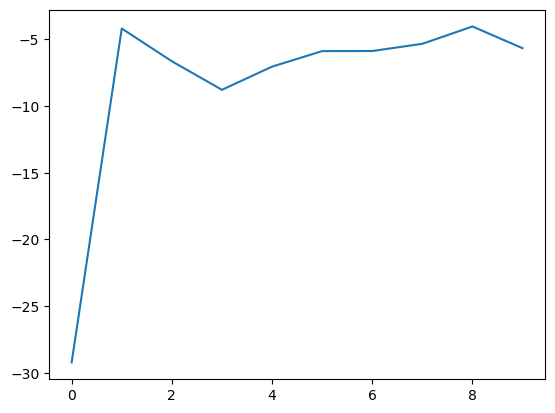

In [4]:
env = make_env(GAMMA, **ENV_ARGS)
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)


print('action = ', action)
print('action shape = ', action.shape)
sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Actor and Critic Net

In [5]:
class ActorNet(nn.Module):

    def __init__(self, state, action, device, hidden_size = 64, lr = 1e-3, grad_clip = 1.0):
        super().__init__()
        self.state = state
        self.action = action
        self.grad_clip = grad_clip

        state_shape = state.shape
        action_shape = action.shape

        self.device = device
        self.lr = lr

        self.action_low = torch.tensor(action.low)
        self.action_high = torch.tensor(action.high)

        self.device = device
        self.net = nn.Sequential(
            nn.Linear(state_shape[0], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size) ,
            nn.ReLU(),
            nn.Linear(hidden_size, action_shape[0])
        )

        self.logstd = nn.Parameter(torch.full(size= action.shape, fill_value=0.1))

        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        self.to(device)

    def forward(self, X):
        X = self.net(X)
        return X
    
    def act(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        mean = self(state)
        std = torch.clamp(self.logstd.exp(), 1e-3, 50)

        action_distribution = torch.distributions.normal.Normal(mean, std)
        action = action_distribution.sample()
        action = torch.clamp(action, self.action_low, self.action_high)
        log_prob = action_distribution.log_prob(action)
        return action.numpy()[0], log_prob
    
    def learn(self, saved_log_probs, advantage):
        actor_loss = (-saved_log_probs * advantage.detach()).mean()
        self.optimizer.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), max_norm=self.grad_clip)
        self.optimizer.step()


In [6]:
class CriticNet(nn.Module):
    def __init__(self, state, device, hidden_size = 64, lr = 1e-3, grad_clip = 1.0):
        super().__init__()
        self.state = state
        self.lr = lr
        self.grad_clip = grad_clip

        self.base = nn.Sequential(
            nn.Linear(state.shape[0], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

        self.device = device
        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)

        self.to(device)

    def forward(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        return self.base(state)
    
    def learn(self, returns, state_values):
        critic_loss = F.mse_loss(returns, state_values)
        self.optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), max_norm=self.grad_clip)
        self.optimizer.step()


In [7]:
# Test model
env = make_env(GAMMA, **ENV_ARGS)
obs, info = env.reset()
state, action = env.observation_space, env.action_space

print('state size = ', state.shape)
print('action size = ', action.shape)

actor = ActorNet(state, action, device = DEVICE)
critic = CriticNet(state, device = DEVICE)

# obs = transform(obs, normalizer)
action, action_prob = actor.act(obs)
print('action = ', action)
print('action prob = ', action_prob)

value = critic(obs)
print('value = ', value)

env.close()

state size =  (24,)
action size =  (4,)
action =  [ 0.15585431  1.         -0.9451599   1.        ]
action prob =  tensor([[-1.0210, -1.3814, -1.3493, -1.4921]], grad_fn=<SubBackward0>)
value =  tensor([[0.0991]], grad_fn=<AddmmBackward0>)


# Compute returns

In [8]:
def compute_returns(rewards, gamma):
    returns = deque(maxlen = len(rewards))
    #compute cummulative reward
    num_steps = len(rewards)

    for t in reversed(range(num_steps)):
        G_t = returns[0] if len(returns) > 0 else 0
        returns.appendleft(gamma * G_t + rewards[t])

    #standardization of returns to make training more stable
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns).float()
    returns = (returns - returns.mean())/(returns.std() + eps)

    return returns


# A2C algo

In [9]:
print(np.finfo(np.float32).eps.item())

1.1920928955078125e-07


In [10]:
def a2c(env, actor: ActorNet, critic: CriticNet, training_epochs, max_t, gamma , plot_update_freq = 50, label = None):
    if label == None:
        label = str(uuid.uuid4()).split('-')[0]
    print('experiment ID = ', label)

    SAVE_PATH = os.path.join(OUTPUT, label)
        
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    config = f'training_epochs={str(training_epochs)}\nmax_t={str(max_t)}\ngamma={str(gamma)}\nactor_lr={str(actor.lr)}\ncritic_lr={critic.lr}'
    with open(os.path.join(SAVE_PATH, 'config.txt'), 'w') as file:
        file.write(config)

    scores_deque = deque(maxlen = 100)
    history = defaultdict(list)
    loop = tqdm(range(training_epochs))
    best_score = -float('inf')

    for e in loop:

        saved_log_probs = []
        rewards = []
        state, info = env.reset()
        dones = []
        state_values = []

        for t in range(max_t):
            done = False
            #normalize state
            action, log_prob = actor.act(state)
            saved_log_probs.append(log_prob)

            state_value = critic(state)
            state_values.append(state_value.squeeze(0))

            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)

            if terminated or truncated:
                done = True
                break
                
            dones.append(done)
        
        #update actor
        scores_deque.append(sum(rewards))
        avg_reward = np.mean(scores_deque)

        state_values = torch.cat(state_values)
        saved_log_probs = torch.cat(saved_log_probs)

        history['reward'].append(avg_reward)

        #optimize critic net

        returns = compute_returns(rewards, gamma)
        # print('state_values  = ', state_values.shape)
        # print('log probs = ', saved_log_probs.shape)

        critic.learn(returns, state_values)

        # print('returns = ', returns.shape)

        #optimize actor net
        
        advantage = (returns - state_values).unsqueeze(1)
        # print('advantage = ', advantage.shape)

        actor.learn(saved_log_probs, advantage)

        #statistics and saving checkpoint
        loop.set_description(f'avg reward = {avg_reward:.2f}')

        if best_score <= avg_reward:
            best_score = avg_reward
            torch.save(actor, os.path.join(SAVE_PATH, 'actor.checkpoint.torch'))
            torch.save(critic, os.path.join(SAVE_PATH, 'critic.checkpoint.torch'))
        
        if e % plot_update_freq == 0:
            plot(history, save_path=FIG_SAVE_PATH)
        
    plot(history, show=True, save_path=FIG_SAVE_PATH)
    torch.save(actor, os.path.join(SAVE_PATH, 'actor.final.torch'))
    torch.save(critic, os.path.join(SAVE_PATH, 'critic.final.torch'))

    return history

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

# Train

In [65]:
training_epochs = 20000
max_t = 1600
gamma = 0.99
lr = 1e-5
hidden_size = 64

device = DEVICE

env = make_env(gamma, **ENV_ARGS)
obs, info = env.reset()
state, action = env.observation_space, env.action_space
print('state size = ', state.shape)
print('action size = ', action.shape)

# model = PolicyNet(state_size, action_size, hidden_size = 16, device = 'cpu')
actor = ActorNet(state, action, hidden_size = hidden_size, device = device, lr = lr, grad_clip= 1.0)
critic = CriticNet(state, hidden_size = hidden_size, device = device, lr = lr, grad_clip= 1.0)

a2c(env, actor, critic, training_epochs=training_epochs, 
max_t = max_t, gamma = gamma, label = 'test')

env.close()

state size =  (24,)
action size =  (4,)
experiment ID =  test


  0%|          | 0/20000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
avg reward = -18.25:  15%|█▌        | 3002/20000 [20:16<2:30:20,  1.88it/s]

In [ ]:
def evaluate(agent, device = DEVICE, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs).to(device)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    print('reward = ', reward)
                    total_rewards.append(reward)
    
    sns.lineplot(y = total_rewards, x = list(range(len(total_rewards))))
    return total_rewards

load path =  /Volumes/SanDisk/NLP_RNN/Reinforcement Learning/policy_gradient/actor_critic/v3/output/bipedal/test/actor.checkpoint.torch


reward = -130.59: 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


<Axes: >

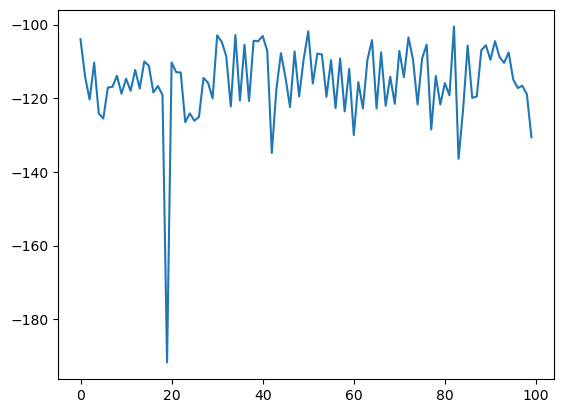

In [13]:
# nv = gym.make('CartPole-v1')
env = gym.make(**ENV_ARGS)
rewards = []

# net = torch.load('best_target_net.torch')
LOAD_PATH = os.path.join(OUTPUT, 'test', 'actor.checkpoint.torch')
print('load path = ', LOAD_PATH)
eval_net = torch.load(LOAD_PATH)

loop = tqdm(range(100))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for t in range(1600):
        action, log_prob = eval_net.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)
    loop.set_description(f'reward = {total_reward:.2f}')
    
sns.lineplot(y = total_rewards, x= list(range(len(total_rewards))))

# Human render

reward = -105.93: 100%|██████████| 5/5 [01:14<00:00, 14.94s/it]


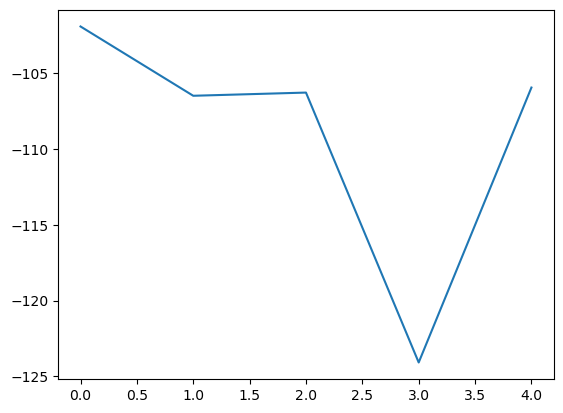

In [15]:
env = gym.make(**ENV_ARGS, render_mode= 'human')
rewards = []

# net = torch.load('best_target_net.torch')
LOAD_PATH = os.path.join(OUTPUT, 'test', 'actor.checkpoint.torch')
eval_net = torch.load(LOAD_PATH)

loop = tqdm(range(5))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for t in range(1600):

        action, log_prob = eval_net.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)
    loop.set_description(f'reward = {total_reward:.2f}')
    
sns.lineplot(y = total_rewards, x= list(range(len(total_rewards))))
env.close()

# References

https://medium.com/deeplearningmadeeasy/advantage-actor-critic-continuous-case-implementation-f55ce5da6b4c